In [16]:
import os
import pathlib
from pathlib import Path
import numpy as np
from skimage import io
from skimage import filters
from skimage import exposure,color
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [17]:
image_folder ="D:\Data Mining\Gowtham_DM_Assignment1\Gowtham_DM_Assignment1\Cropped"

In [18]:
def angle(dx, dy):
    return np.mod(np.arctan2(dy, dx), np.pi)

def edge_histogram(image):
    gradient_angle = angle(filters.sobel_h(image), filters.sobel_v(image))
    histogram, _ = exposure.histogram(gradient_angle, nbins=36)
    return histogram

# Prepare input and label lists
inputs, labels = [], []

# Iterate over each dog class in the image folder
for index, dog_folder in enumerate(tqdm(os.listdir(image_folder))):
    folder_path = os.path.join(image_folder, dog_folder)
    if os.path.isdir(folder_path): 
        # Process each image file within the dog folder
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path):
                img = io.imread(file_path)
                gray_img = color.rgb2gray(img)
                histogram = edge_histogram(gray_img)
                inputs.append(histogram)
                labels.append(index)

# Convert lists to numpy arrays
inputs = np.array(inputs)
labels = np.array(labels)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


In [19]:
print(len(inputs))

832


In [20]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(
    inputs, labels, test_size=0.2, random_state=42, stratify=labels
)

# Check the size of the splits
print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")

Training set size: 665, Test set size: 167


In [21]:
print(X_train)  # Displays the contents of X_train

[[544 492 520 ... 453 474 462]
 [363 325 317 ... 367 335 382]
 [617 450 504 ... 525 492 484]
 ...
 [443 430 407 ... 453 434 405]
 [393 388 386 ... 410 422 451]
 [451 456 454 ... 445 413 487]]


In [22]:
# Initialize the scaler
scaler = preprocessing.StandardScaler()

# Fit the scaler on the training data and transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler to transform the test data
X_test = scaler.transform(X_test)

# Optional: Check the transformed data
print(f"X_train (after scaling):\n{X_train}")
print(f"X_test (after scaling):\n{X_test}")

X_train (after scaling):
[[-0.26051585  0.05548575  0.60430432 ... -0.12079218 -0.1034636
  -0.27797185]
 [-0.71836903 -1.37819724 -1.5423173  ... -1.0440887  -1.30901735
  -0.78590968]
 [-0.07585684 -0.30508123  0.43511246 ...  0.65220026  0.05265127
  -0.13828894]
 ...
 [-0.51600298 -0.47677979 -0.59061313 ... -0.12079218 -0.45038554
  -0.63987755]
 [-0.64248176 -0.83734677 -0.81267744 ... -0.58244044 -0.55446213
  -0.3478133 ]
 [-0.49576638 -0.25357166 -0.09361207 ... -0.20668022 -0.63251956
  -0.11924127]]
X_test (after scaling):
[[-0.51094383 -0.60555371 -0.58003864 ...  0.10466395 -0.46773164
  -0.45575009]
 [-0.10368217  0.63926085  0.63602779 ...  1.33930465  1.37095465
   0.76964994]
 [-0.19474689 -0.86310155 -0.75980498 ... -0.82936858 -1.07484504
  -1.12876772]
 ...
 [ 0.1062726  -0.76866735 -0.82325193 ...  0.0080399   0.09601652
   0.17282298]
 [ 0.55400748  0.27010895  0.24477163 ...  0.48042416  0.37355407
   0.02679086]
 [-0.23016094 -0.11621282  0.44568696 ... -0.71127

In [23]:
from sklearn.model_selection import StratifiedKFold

# Initialize StratifiedKFold
skf1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Gaussian Naive Bayes Classifier
mean-validation-accuracy: 0.32781954887218046
test-accuracy: 0.2994011976047904
f1-measure: 0.28031234922616816


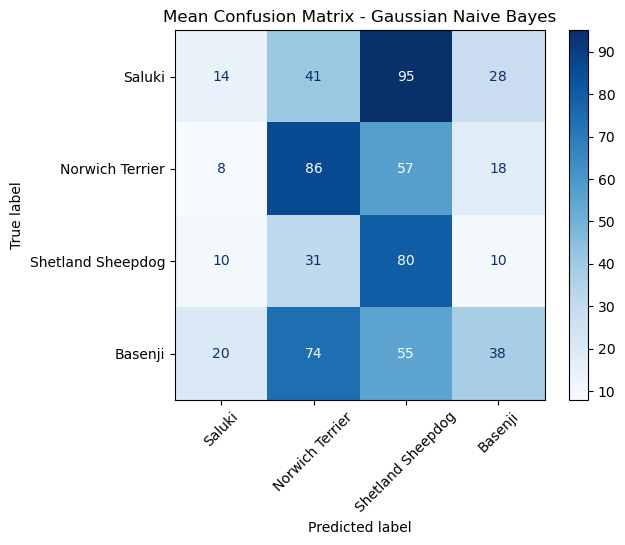

In [24]:
from sklearn.naive_bayes import GaussianNB

# Initialize the Gaussian Naive Bayes classifier
gnb_classifier = GaussianNB()

print("Gaussian Naive Bayes Classifier")
true, predict, valaccu = [], [], []
cm = []

for train_index, test_index in skf1.split(X_train, y_train):
    xtrain, xval = X_train[train_index], X_train[test_index]
    ytrain, yval = y_train[train_index], y_train[test_index]
    
    gnb_classifier.fit(xtrain, ytrain)
    pred = gnb_classifier.predict(xval)
    
    true.extend(yval)
    predict.extend(pred)
    val_acc = accuracy_score(yval, pred)
    valaccu.append(val_acc)

print("mean-validation-accuracy: " + str(np.mean(valaccu)))

# Test accuracy
test_acc = accuracy_score(y_test, gnb_classifier.predict(X_test))
print("test-accuracy: " + str(test_acc))

# F1 score
f1 = f1_score(y_test, gnb_classifier.predict(X_test), average='weighted')
print("f1-measure: " + str(f1))

# Calculate confusion matrix
cm.append(confusion_matrix(true, predict))

# Calculate mean confusion matrix for Gaussian Naive Bayes
mean_cm_gnb = np.mean(cm, axis=0)

# Plot mean confusion matrix for Gaussian Naive Bayes
cm_display = ConfusionMatrixDisplay(confusion_matrix=mean_cm_gnb, display_labels=['Saluki', 'Norwich Terrier', 'Shetland Sheepdog', 'Basenji'])
cm_display.plot(xticks_rotation=45, cmap=plt.cm.Blues)
plt.title("Mean Confusion Matrix - Gaussian Naive Bayes")
plt.show()


Support Vector Machine (SVM)


C:\Users\Gowtham reddy\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Gowtham reddy\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Gowtham reddy\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Gowtham reddy\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


mean-validation-accuracy: 0.3593984962406015
test-accuracy: 0.39520958083832336
f1-measure: 0.39156998529070314


C:\Users\Gowtham reddy\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


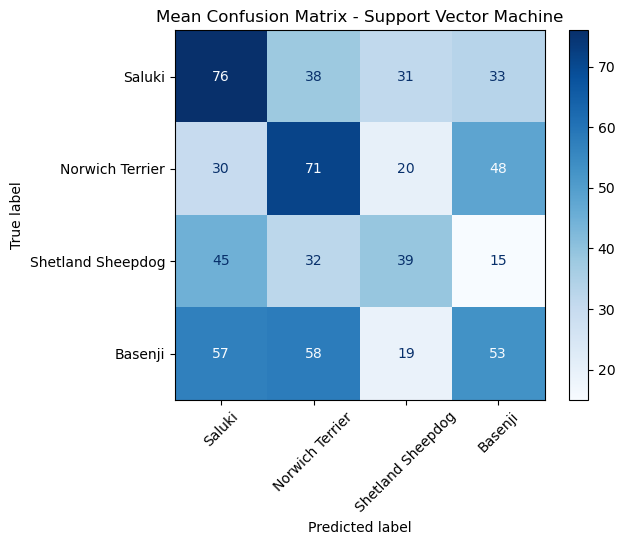

In [25]:
from sklearn.svm import LinearSVC

# Initialize the SVM classifier
svm_classifier = LinearSVC()

print("Support Vector Machine (SVM)")
true, predict, valaccu = [], [], []
cm = []

for train_index, test_index in skf1.split(X_train, y_train):
    xtrain, xval = X_train[train_index], X_train[test_index]
    ytrain, yval = y_train[train_index], y_train[test_index]
    
    svm_classifier.fit(xtrain, ytrain)
    pred = svm_classifier.predict(xval)
    
    true.extend(yval)
    predict.extend(pred)
    val_acc = accuracy_score(yval, pred)
    valaccu.append(val_acc)

print("mean-validation-accuracy: " + str(np.mean(valaccu)))

# Test accuracy
test_acc = accuracy_score(y_test, svm_classifier.predict(X_test))
print("test-accuracy: " + str(test_acc))

# F1 score
f1 = f1_score(y_test, svm_classifier.predict(X_test), average='weighted')
print("f1-measure: " + str(f1))

# Calculate confusion matrix
cm.append(confusion_matrix(true, predict))

# Calculate mean confusion matrix for SVM
mean_cm_svm = np.mean(cm, axis=0)

# Plot mean confusion matrix for SVM
cm_display = ConfusionMatrixDisplay(confusion_matrix=mean_cm_svm, display_labels=['Saluki', 'Norwich Terrier', 'Shetland Sheepdog', 'Basenji'])
cm_display.plot(xticks_rotation=45, cmap=plt.cm.Blues)
plt.title("Mean Confusion Matrix - Support Vector Machine")
plt.show()


RandomForestClassifier
mean-validation-accuracy: 0.3714285714285714
test-accuracy: 0.3652694610778443
f1-measure: 0.36075470687583133


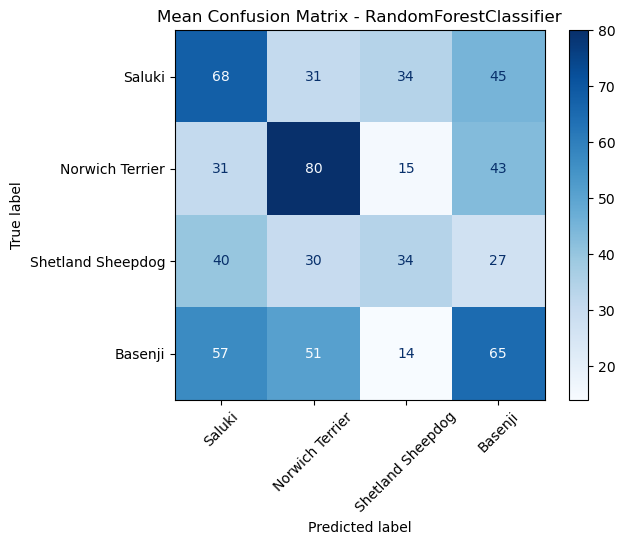

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# Define StratifiedKFold
skf1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

print("RandomForestClassifier")
true, predict, valaccu = [], [], []
cm = []  # To store confusion matrices

for train_index, test_index in skf1.split(X_train, y_train):
    xtrain, xval = X_train[train_index], X_train[test_index]
    ytrain, yval = y_train[train_index], y_train[test_index]
    
    rf_classifier.fit(xtrain, ytrain)
    pred = rf_classifier.predict(xval)
    
    true.extend(yval)
    predict.extend(pred)
    val_acc = accuracy_score(yval, pred)
    valaccu.append(val_acc)

print("mean-validation-accuracy: " + str(np.mean(valaccu)))

# Test accuracy
test_acc = accuracy_score(y_test, rf_classifier.predict(X_test))
print("test-accuracy: " + str(test_acc))

# F1 score
f1 = f1_score(y_test, rf_classifier.predict(X_test), average='weighted')
print("f1-measure: " + str(f1))

# Calculate confusion matrix
cm.append(confusion_matrix(true, predict))

# Calculate mean confusion matrix for RandomForestClassifier
mean_cm_rf = np.mean(cm, axis=0)

# Plot mean confusion matrix for RandomForestClassifier
cm_display = ConfusionMatrixDisplay(confusion_matrix=mean_cm_rf, display_labels=['Saluki', 'Norwich Terrier', 'Shetland Sheepdog', 'Basenji'])
cm_display.plot(xticks_rotation=45, cmap=plt.cm.Blues)
plt.title("Mean Confusion Matrix - RandomForestClassifier")
plt.show()


**Confusion matrix analysis:**


By visually comparing from three confusion matrices, **"RANDOM FOREST CLASSIFIER"** appears to be the **best method** as it shows more consistent performance across all classes,higher diagonal values.The SVM and Naive bayes are showing some correct classifications, need refinement to improve their overall performance.



**Mean Validation Accuracy:**

Naive Bayes Classifier: 0.32781954887218046,

SVM Classifier: 0.3593984962406015,

Random Forest Classifier: 0.3714285714285714.

**Best: Random Forest (0.3714)**

Among these, the **Random Forest Classifier** achieved the highest mean validation accuracy of 0.3714.This indicates that it is the most effective model for classifying the images in this dataset, demonstrating better performance than both the Naive Bayes and SVM classifiers.




**Test Accuracy:**

Naive Bayes Classifier: 0.2994011976047904,

SVM Classifier: 0.39520958083832336,

Random Forest Classifier: 0.3652694610778443.

**Best: SVM (0.3952)**

The **SVM Classifier** achieved the highest test accuracy at 0.3952, making it the best-performing model for this dataset on the test set. This indicates that the SVM classifier was more effective in correctly classifying the images compared to both the Naive Bayes and Random Forest classifiers.

**F1 Measure:**

Naive Bayes Classifier: 0.2994011976047904,

SVM Classifier: 0.39156998529070314,

Random Forest Classifier: 0.28031234922616816.

**Best: SVM (0.3916)**

The **SVM Classifier** achieved the highest F1 measure at 0.3916, indicating that it outperformed the other models in balancing precision and recall for the classification task. This suggests that the SVM classifier is effective at minimizing both false positives and false negatives, leading to better overall performance in identifying the correct classes.

In SVM, a low \( C \) value simplifies the model, often leading to underfitting, while a high \( C \) makes it more complex by tightly fitting the training data. In this analysis, \( C = 100 \) provides the lowest validation error, suggesting an optimal complexity for accuracy on the dataset. However, this high \( C \) may risk overfitting if increased further, as it focuses more on capturing training data details.

C:\Users\Gowtham reddy\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Gowtham reddy\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Gowtham reddy\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Gowtham reddy\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Gowtham reddy\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Gowtham reddy\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Li

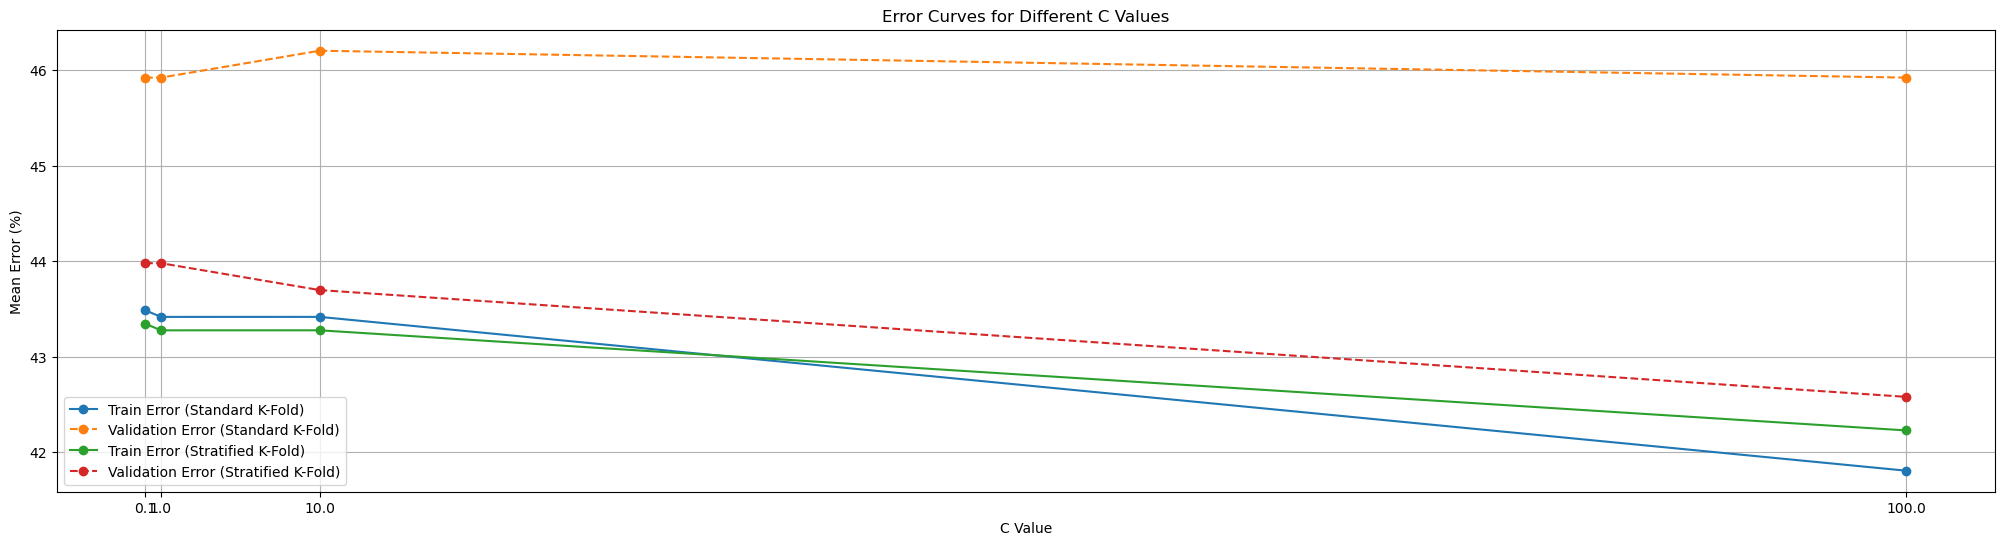

Low C value: 100
Mean Validation Error at Best C: 0.43
Test Error with Low C: 0.42
Low C for Training Error (Standard K-Fold): 100
Low C for Validation Error (Standard K-Fold): 0.1
Low C for Training Error (Stratified K-Fold): 100
Low C for Validation Error (Stratified K-Fold): 100


C:\Users\Gowtham reddy\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [106]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Function to compute edge histogram features
def compute_edge_histogram(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)  # Use Canny edge detection
    hist = cv2.calcHist([edges], [0], None, [256], [0, 256]).flatten()  # Calculate histogram of edges
    return hist

# Load images and labels from folder
def load_data(folder_path):
    X = []
    y = []
    for label in ['n02091831-Saluki', 'n02105855-Shetland_sheepdog']:
        label_folder = os.path.join(folder_path, label)
        for filename in os.listdir(label_folder):
            if filename.endswith('.jpg'):
                img_path = os.path.join(label_folder, filename)
                hist = compute_edge_histogram(img_path)
                X.append(hist)  # Append histogram features
                y.append(label)  # Append corresponding label
    return np.array(X), np.array(y)

# Load data
folder_path = 'C:/Users/Gowtham reddy/Gowtham_DM_Assignment1/GowthamImages'
X, y = load_data(folder_path)

# Filter dataset for Saluki and Shetland Sheepdog
X_binary = X[np.isin(y, ['n02091831-Saluki', 'n02105855-Shetland_sheepdog'])]
y_binary = np.where(y == 'n02091831-Saluki', 0, 1)  # 0 for Saluki, 1 for Shetland Sheepdog

# Standardize the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_binary)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y_binary, test_size=0.2, random_state=42)

# Set up parameters for C values
C_values = [0.1, 1, 10, 100]
train_errors = []
val_errors = []

# Perform standard and stratified 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Standard K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Stratified K-Fold

# Function to compute errors
def compute_errors(splits, X, y):
    train_error = []
    val_error = []
    for C in C_values:
        svc = LinearSVC(C=C, max_iter=10000)  # Initialize the SVM classifier
        for train_index, val_index in splits.split(X, y):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            svc.fit(X_train, y_train)  # Train the model
            y_train_pred = svc.predict(X_train)  # Predictions on training set
            y_val_pred = svc.predict(X_val)  # Predictions on validation set
            train_error.append(1 - accuracy_score(y_train, y_train_pred))  # Calculate training error
            val_error.append(1 - accuracy_score(y_val, y_val_pred))  # Calculate validation error
    return train_error, val_error

# Compute training and validation errors using standard K-Fold
train_error_standard, val_error_standard = compute_errors(kf, X_standardized, y_binary)

# Compute training and validation errors using stratified K-Fold
train_error_stratified, val_error_stratified = compute_errors(skf, X_standardized, y_binary)

# Reshape errors for plotting
train_error_standard = np.array(train_error_standard).reshape(len(C_values), -1)
val_error_standard = np.array(val_error_standard).reshape(len(C_values), -1)
train_error_stratified = np.array(train_error_stratified).reshape(len(C_values), -1)
val_error_stratified = np.array(val_error_stratified).reshape(len(C_values), -1)

# Calculate mean errors
mean_train_error_standard = np.mean(train_error_standard, axis=1)
mean_val_error_standard = np.mean(val_error_standard, axis=1)
mean_train_error_stratified = np.mean(train_error_stratified, axis=1)
mean_val_error_stratified = np.mean(val_error_stratified, axis=1)

# Plotting the error curves
plt.figure(figsize=(25, 6))
plt.plot(C_values, mean_train_error_standard * 100, label='Train Error (Standard K-Fold)', marker='o', linestyle='-')
plt.plot(C_values, mean_val_error_standard * 100, label='Validation Error (Standard K-Fold)', marker='o', linestyle='--')
plt.plot(C_values, mean_train_error_stratified * 100, label='Train Error (Stratified K-Fold)', marker='o', linestyle='-')
plt.plot(C_values, mean_val_error_stratified * 100, label='Validation Error (Stratified K-Fold)', marker='o', linestyle='--')
plt.xlabel('C Value')
plt.ylabel('Mean Error (%)')
plt.title('Error Curves for Different C Values')
plt.xticks(C_values)
plt.legend()
plt.grid()
plt.show()

# Identify the Low C value based on the lowest mean validation error from stratified
Low_c_index = np.argmin(mean_val_error_stratified)
Low_C = C_values[Low_c_index]
mean_val_error_Low_C = mean_val_error_stratified[Low_c_index]

print(f"Low C value: {Low_C}")
print(f"Mean Validation Error at Best C: {mean_val_error_Low_C:.2f}")

# Evaluate test error with the Low C value
Low_model = LinearSVC(C=Low_C, max_iter=10000)
Low_model.fit(X_train, y_train)
test_predictions = Low_model.predict(X_test)
test_error = 1 - accuracy_score(y_test, test_predictions)

print(f"Test Error with Low C: {test_error:.2f}")

# Find the Low C for each curve based on the lowest mean error
Low_C_train_standard = C_values[np.argmin(mean_train_error_standard)]
Low_C_val_standard = C_values[np.argmin(mean_val_error_standard)]
Low_C_train_stratified = C_values[np.argmin(mean_train_error_stratified)]
Low_C_val_stratified = C_values[np.argmin(mean_val_error_stratified)]

# Display the results
print(f"Low C for Training Error (Standard K-Fold): {Low_C_train_standard}")
print(f"Low C for Validation Error (Standard K-Fold): {Low_C_val_standard}")
print(f"Low C for Training Error (Stratified K-Fold): {Low_C_train_stratified}")
print(f"Low C for Validation Error (Stratified K-Fold): {Low_C_val_stratified}")


The model appears to be overfitting, as the training error is minimized at a high 
C value (100), but validation and test errors remain relatively high. The discrepancy between training and validation 
C values in standard K-Fold further suggests the model is sensitive to the training data, performing better on validation at a lower 
C. This indicates that while 
C=100 may fit the training data well, it reduces the model's generalizability on unseen data.

References:
1. Confusion matrix: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
2. Confusion matrix display: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
3. Gaussian Naive Bayes Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
4. SVM classifier: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
5. Random forest classifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
6. Performance Metrics: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
